In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.api.models import Sequential
from keras.api.models import model_from_json 
from keras.api.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from enum import Enum
from pathlib import Path


In [8]:
class DataType(Enum):
    TRAINING = 'train'
    TESTING = 'test'


def get_disease_dict():
    return {
        0: 'Acne and Rosacea',
        1: 'Cellulitis Impetigo and other Bacterial Infections',
        2: 'Eczema',
        3: 'Light Diseases and Disorders of Pigmentation',
        4: 'Psoriasis Lichen Planus and related diseases',
        5: 'Seborrheic Keratoses and other Benign Tumors',
        6: 'Urticaria Hives',
        7: 'Vascular Tumors',
    }


def get_data_path(data_type=DataType.TRAINING):
    return f'dataset/{data_type.value}/'


def get_model_json_path():
    folderPath = Path(f'model')
    folderPath.mkdir(parents=True, exist_ok=True)

    path = Path(f'{folderPath}/skin_disease_detection_model.json')

    return path


def get_model_h5_path():
    folderPath = Path(f'model')
    folderPath.mkdir(parents=True, exist_ok=True)

    path = Path(f'{folderPath}/skin_disease_detection_model.weights.h5')
    return path

In [ ]:
import os

train_data_path = get_data_path()

disease_names = sorted(os.listdir(train_data_path))
num_diseases = len(disease_names)

img_size = (192, 192, 3)

In [11]:
import cv2

labels = []
images = []

for disease in disease_names:
    for img in os.listdir(train_data_path + disease):
        label = np.zeros(num_diseases)
        label[disease_names.index(disease)] = 1
        labels.append(label)
        
        image = np.asarray(cv2.resize(cv2.imread(train_data_path + disease + '/' + img, cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1])
        images.append(image)


labels_data = np.asarray(labels)
images_data = np.asarray(images)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(images_data, labels_data, test_size=0.15, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (1255, 192, 192, 3)
train labels shape: (1255, 8)

validation images shape: (222, 192, 192, 3)
validation labels shape: (222, 8)



In [15]:
import tensorflow as tf

skin_disease_detection_model = Sequential()

# Inputs and rescaling
skin_disease_detection_model.add(Rescaling(scale=1. / 255, input_shape=(img_size)))

# Convolutional block 1
skin_disease_detection_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
skin_disease_detection_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
skin_disease_detection_model.add(MaxPooling2D(pool_size=2))

# Convolutional block 2
skin_disease_detection_model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
skin_disease_detection_model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
skin_disease_detection_model.add(MaxPooling2D(pool_size=2))

# Convolutional block 3
skin_disease_detection_model.add(Conv2D(256, (2, 2), activation='relu', padding='same'))
skin_disease_detection_model.add(Conv2D(256, (2, 2), activation='relu', padding='same'))
skin_disease_detection_model.add(MaxPooling2D(pool_size=2))

# Convolutional block 4
skin_disease_detection_model.add(Conv2D(512, (2, 2), activation='relu', padding='same'))
skin_disease_detection_model.add(Conv2D(512, (2, 2), activation='relu', padding='same'))
skin_disease_detection_model.add(MaxPooling2D(pool_size=2))
skin_disease_detection_model.add(Flatten())

# Dense block
skin_disease_detection_model.add(Dense(256, activation='relu'))
skin_disease_detection_model.add(Dense(128, activation='relu'))
skin_disease_detection_model.add(Dense(64, activation='relu'))
skin_disease_detection_model.add(Dense(num_diseases, activation='softmax'))


skin_disease_detection_model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

skin_disease_detection_model.summary()

/Users/smrslymnl/Desktop/Master/Artificial Intelligence/.venv/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 192, 192, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 192, 192, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 256)    │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 512)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 512)    │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,021,192 (80.19 MB)

 Trainable params: 21,021,192 (80.19 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from keras.api.callbacks import ModelCheckpoint

# creating ModelChecpoint callback
checkpoint_callback = ModelCheckpoint('skin_disease_detection_model/model{epoch:02d}.keras')

In [21]:
history = skin_disease_detection_model.fit(images_data, labels_data, epochs=20, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 0.5681 - loss: 1.3506 - val_accuracy: 0.5721 - val_loss: 1.3072
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step - accuracy: 0.5616 - loss: 1.3637 - val_accuracy: 0.5766 - val_loss: 1.2527
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - accuracy: 0.5677 - loss: 1.3279 - val_accuracy: 0.5811 - val_loss: 1.2460
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 260s 6s/step - accuracy: 0.5937 - loss: 1.2715 - val_accuracy: 0.5991 - val_loss: 1.1788
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 300s 6s/step - accuracy: 0.5805 - loss: 1.2475 - val_accuracy: 0.6081 - val_loss: 1.1757
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 306s 7s/step - accuracy: 0.5811 - loss: 1.2301 - val_accuracy: 0.6126 - val_loss: 1.1282
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 329s 7s/step - accuracy: 0.5877 - loss: 1.1892 - val_accuracy: 0.6081 - val_loss: 1.0979
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 330s 7s/step - accuracy: 0.5814 - loss: 1.1828 - val_accuracy: 0.6216 - v

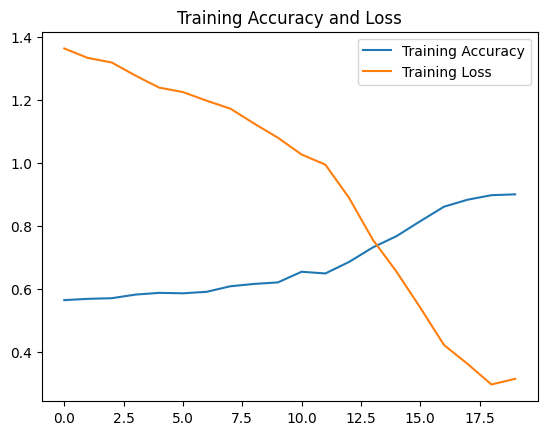

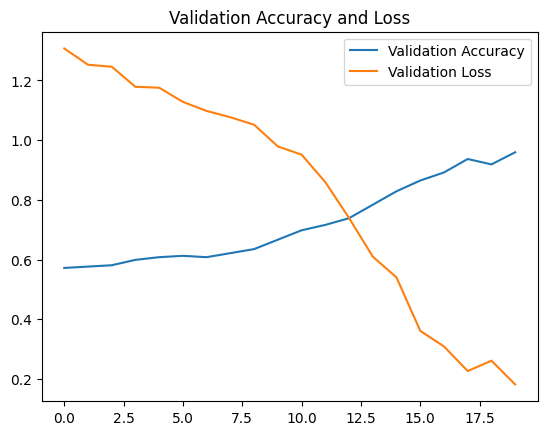

In [22]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()

/var/folders/fy/bvd2ywk51j39jbmnl0btwj880000gn/T/ipykernel_3025/3290344925.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="20")


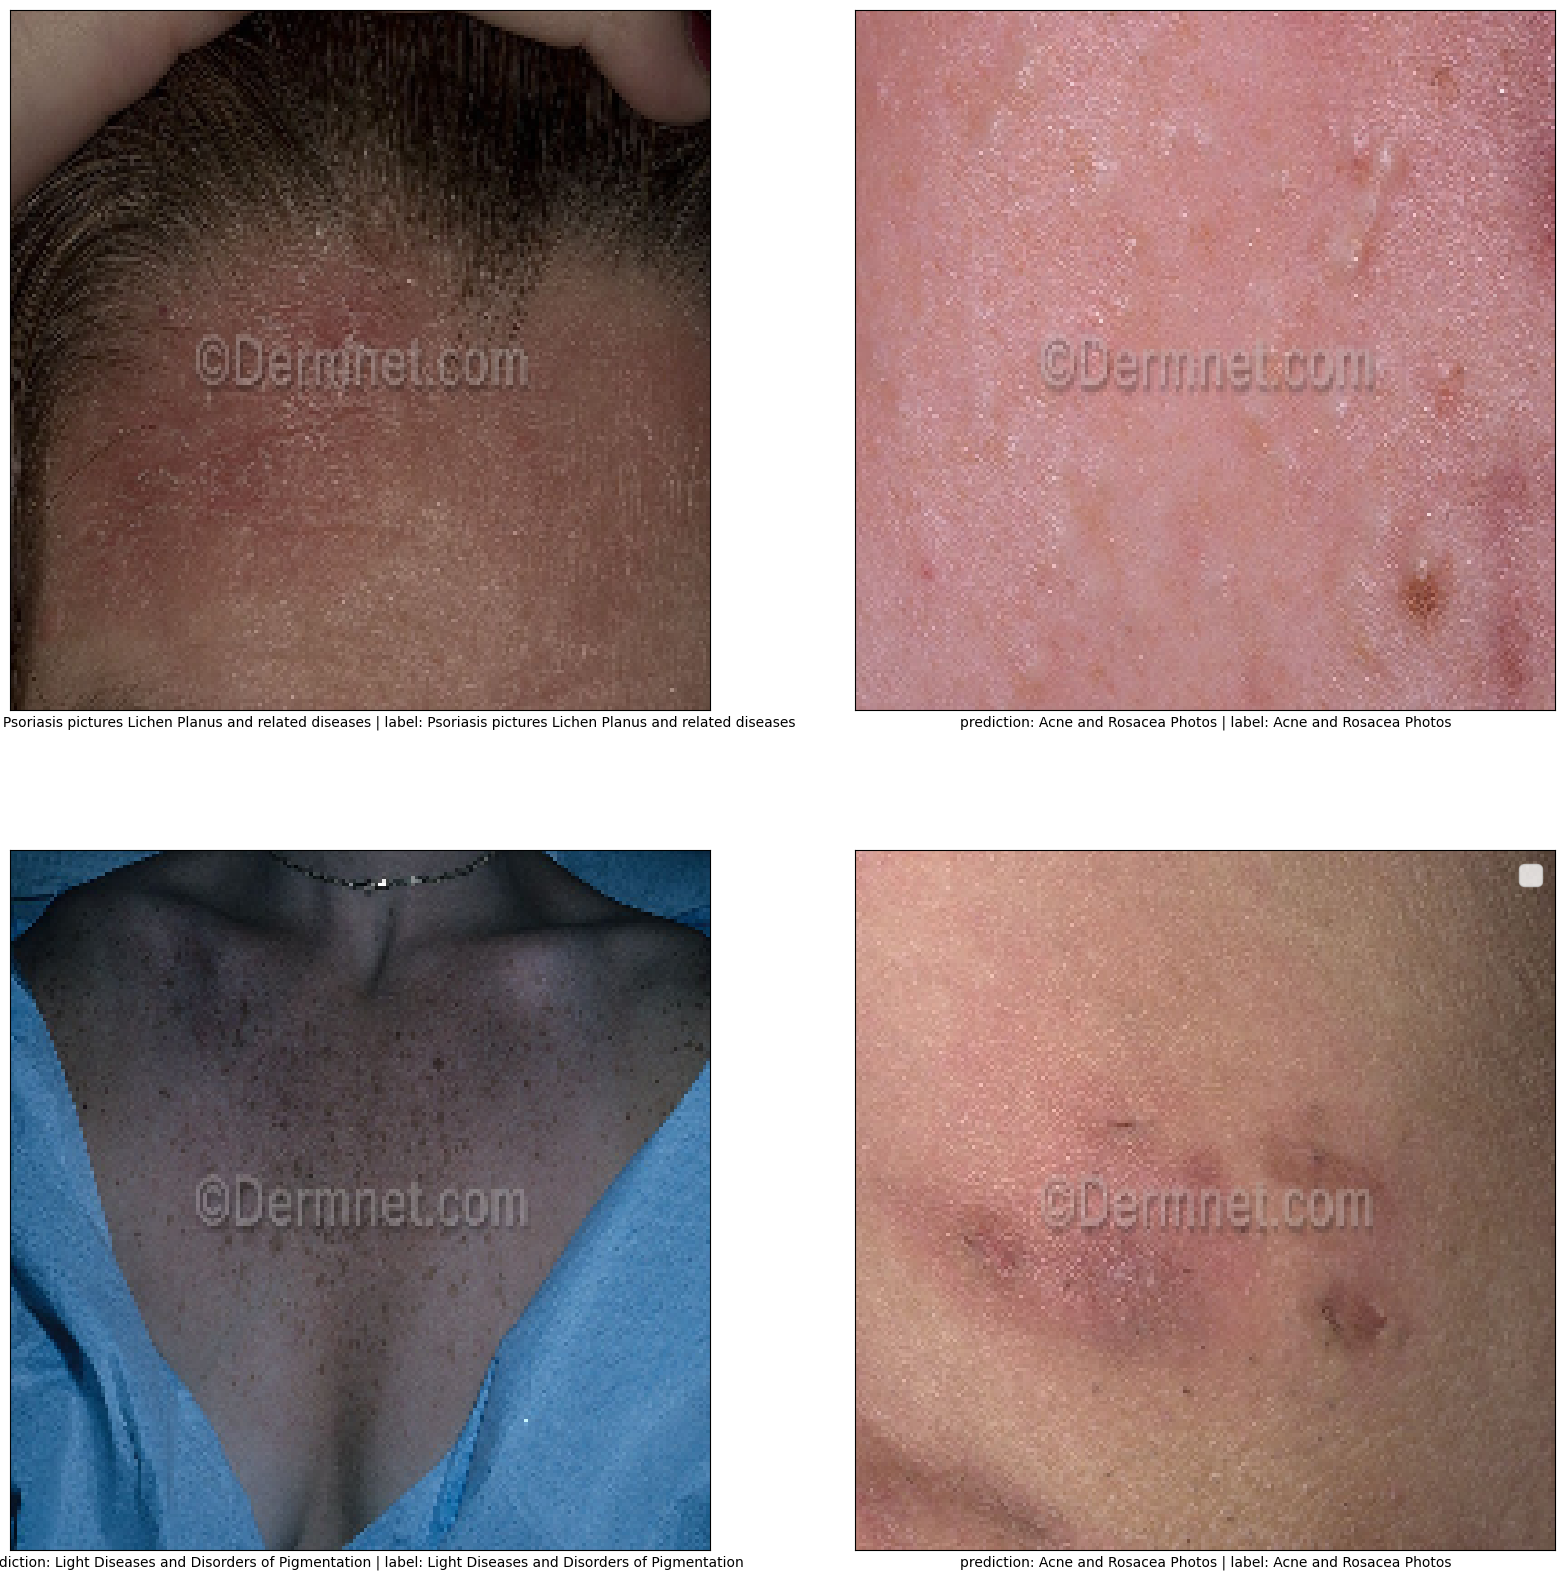

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
plt.legend(fontsize="20")

i = 0
for x in range(2):
    for y in range(2):
        prediction = skin_disease_detection_model.predict(X_val[i][None, ...], verbose=0)[0],

        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(f'prediction: {disease_names[np.argmax(prediction)]} | label: {disease_names[np.argmax(y_val[i])]}')

        axs[x][y].imshow(X_val[i])
        
        i += 1
plt.show()


Saving model in JSON:

In [ ]:
model_json = skin_disease_detection_model.to_json() 
with open(get_model_json_path(), "w+") as json_file: 
    json_file.write(model_json)
  
# save trained model weight in .h5 file 
skin_disease_detection_model.save_weights(get_model_h5_path()) 

Take model as JSON and create model using it:

In [ ]:
json_file = open(get_model_json_path(), 'r') 
loaded_model_json = json_file.read() 
json_file.close() 
emotion_model = model_from_json(loaded_model_json) 